In [55]:
from datetime import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("../Data/temperature.csv")
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [3]:
# Would like to have TxD

# We'll choose 2 cities (D=2)

In [4]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s, "%Y-%m-%d")

In [5]:
df["Date"] = df.apply(parse_date, axis=1)

In [6]:
auckland = df.query("City == 'Auckland'").copy().dropna()
stockholm = df.query("City == 'Stockholm'").copy().dropna()

In [7]:
# keep only columns we want
auckland = auckland[["Date", "AverageTemperatureFahr"]].copy()
stockholm = stockholm[["Date", "AverageTemperatureFahr"]].copy()

In [8]:
# set index to date col
auckland.set_index(auckland["Date"], inplace=True)
auckland.drop("Date", axis=1, inplace=True)
auckland.columns = ["AucklandTemp"]

In [9]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [10]:
stockholm.set_index(stockholm["Date"], inplace=True)
stockholm.drop("Date", axis=1, inplace=True)
stockholm.columns = ["StockholmTemp"]

In [11]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [12]:
joined = auckland.join(stockholm, how="outer") # has some missing data

In [13]:
joined.shape

(3155, 2)

In [14]:
# 3155 is large number of records to handle by VARMA. So will choose the last 500 records
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = "MS"

In [15]:
# how many missing values to the dataset
joined_part.isnull().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [16]:
# Now fill those missing values. But keep in remember that don't do this with stock prices!
# interpolate method documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html
joined_part.interpolate(inplace=True)

In [17]:
# again check total missing values
joined_part.isnull().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

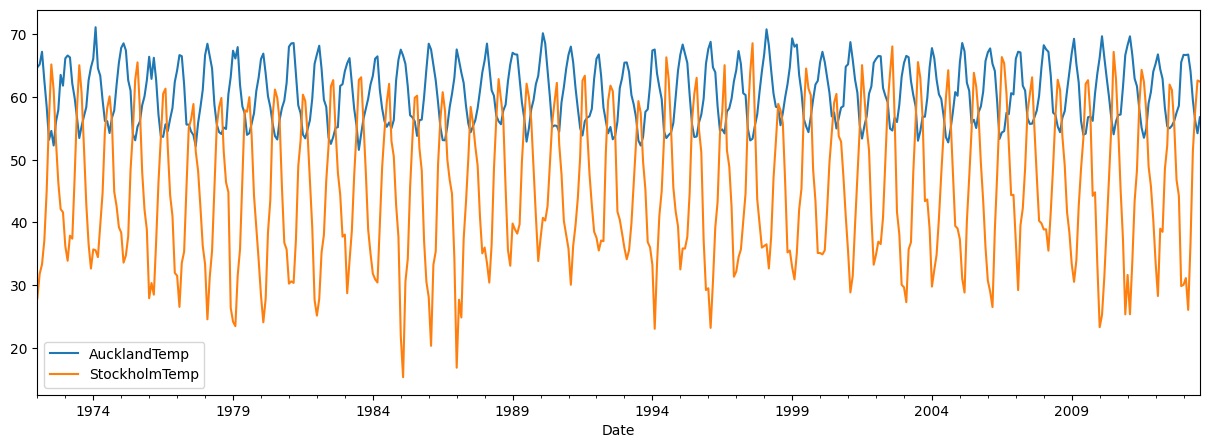

In [18]:
joined_part.plot(figsize=(15, 5));

## VARMA

In [19]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [20]:
# standardize the wide range of the temperature for the Auckland city
scaler_auckland = StandardScaler()
train["ScaledAuckland"] = scaler_auckland.fit_transform(train[["AucklandTemp"]])
test["ScaledAuckland"]  = scaler_auckland.transform(test[["AucklandTemp"]])

In [21]:
# standardize the wide range of the temperature for the Stockholm city
scaler_stockholm = StandardScaler()
train["ScaledStockholm"] = scaler_stockholm.fit_transform(train[["StockholmTemp"]])
test["ScaledStockholm"]  = scaler_stockholm.transform(test[["StockholmTemp"]]) 

In [22]:
train_idx = joined_part.index <= train.index[-1]
test_idx  = joined_part.index > train.index[-1]

In [23]:
# put them back in original df
joined_part.loc[train_idx, "ScaledAuckland"]  = train["ScaledAuckland"]
joined_part.loc[test_idx, "ScaledAuckland"]   = test["ScaledAuckland"]
joined_part.loc[train_idx, "ScaledStockholm"] = train["ScaledStockholm"]
joined_part.loc[test_idx, "ScaledStockholm"]  = test["ScaledStockholm"]

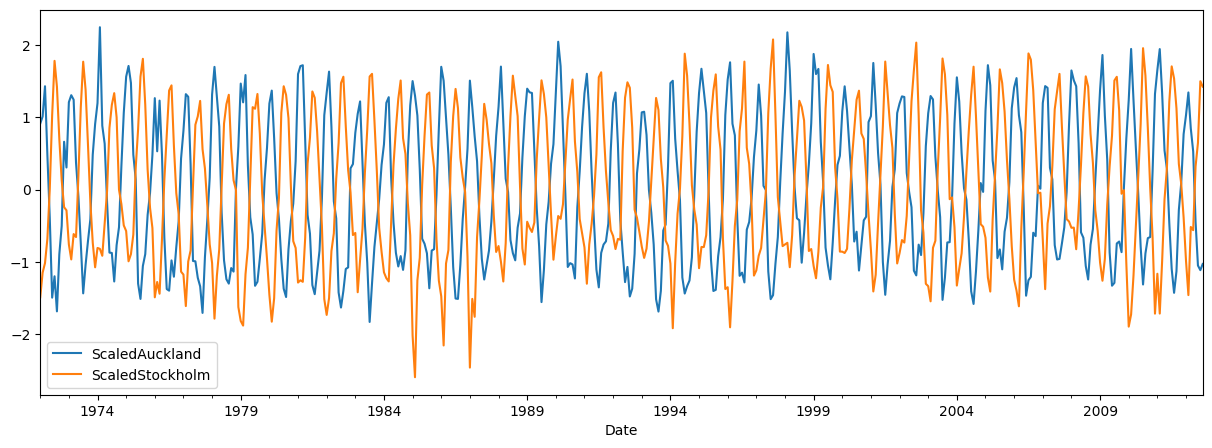

In [24]:
cols = ["ScaledAuckland", "ScaledStockholm"]
train[cols].plot(figsize=(15, 5));

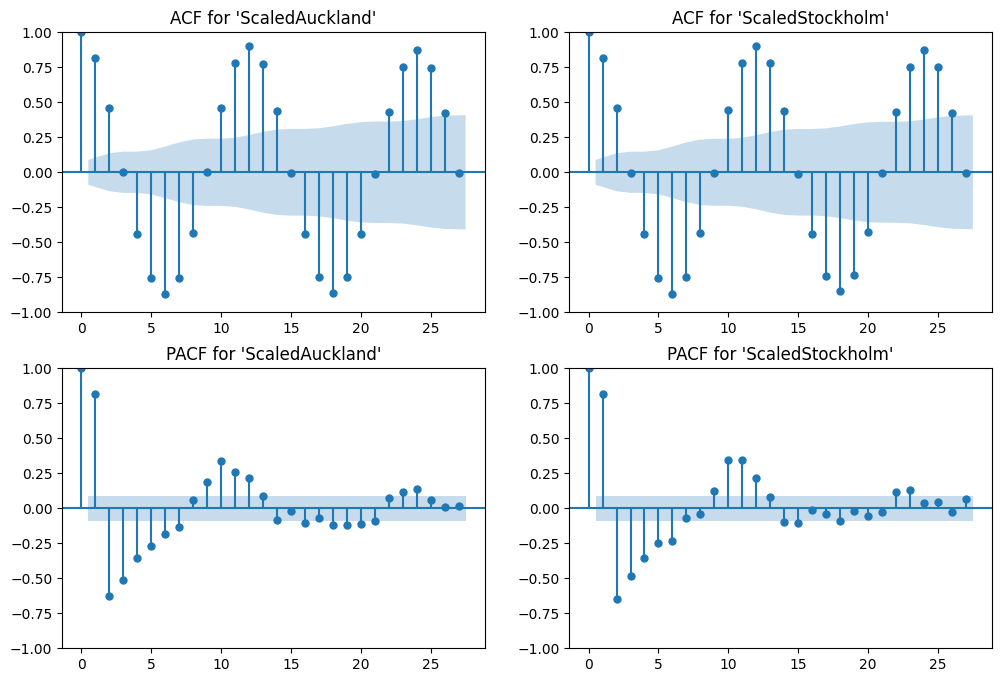

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(train["ScaledAuckland"], ax=axs[0][0])
axs[0][0].set_title("ACF for 'ScaledAuckland'")

plot_acf(train["ScaledStockholm"], ax=axs[0][1])
axs[0][1].set_title("ACF for 'ScaledStockholm'")

plot_pacf(train["ScaledAuckland"], ax=axs[1][0])
axs[1][0].set_title("PACF for 'ScaledAuckland'")

plot_pacf(train["ScaledStockholm"], ax=axs[1][1])
axs[1][1].set_title("PACF for 'ScaledStockholm'")

plt.show()

# throughout the graphs, we can see a strong seasonal pattern.

In [31]:
# is used to measure how long the model took to train
t0 = time.time()
# for no particular reason p=10 and q=10 have been chosen
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter=100)
print(f"Duration: {time.time() - t0} seconds")

c:\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 384.85825991630554 seconds


In [32]:
# Get the forecast for the Ntest time-steps
fcast = res.get_forecast(Ntest)

In [33]:
res.fittedvalues["ScaledAuckland"]

Date
1972-01-01   -0.005775
1972-02-01    0.832682
1972-03-01    0.720774
1972-04-01    0.824820
1972-05-01   -0.087473
                ...   
2012-04-01    0.524063
2012-05-01   -0.291382
2012-06-01   -1.069820
2012-07-01   -1.330058
2012-08-01   -1.061859
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [34]:
joined_part.loc[train_idx, "Train Pred Auckland"] = res.fittedvalues["ScaledAuckland"]
joined_part.loc[test_idx, "Test Pred Auckland"]   = fcast.predicted_mean["ScaledAuckland"]

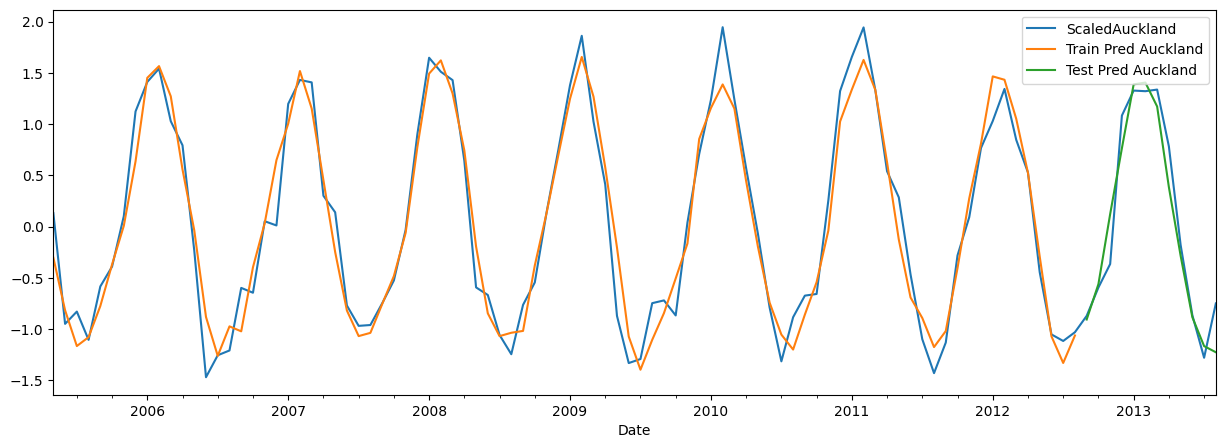

In [36]:
plot_cols = ["ScaledAuckland", "Train Pred Auckland", "Test Pred Auckland"]
joined_part.iloc[-100:][plot_cols].plot(figsize = (15, 5));

In [38]:
joined_part.loc[train_idx, "Train Pred Stockholm"] = res.fittedvalues["ScaledStockholm"]
joined_part.loc[test_idx, "Test Pred Stockholm"]   = fcast.predicted_mean["ScaledStockholm"]

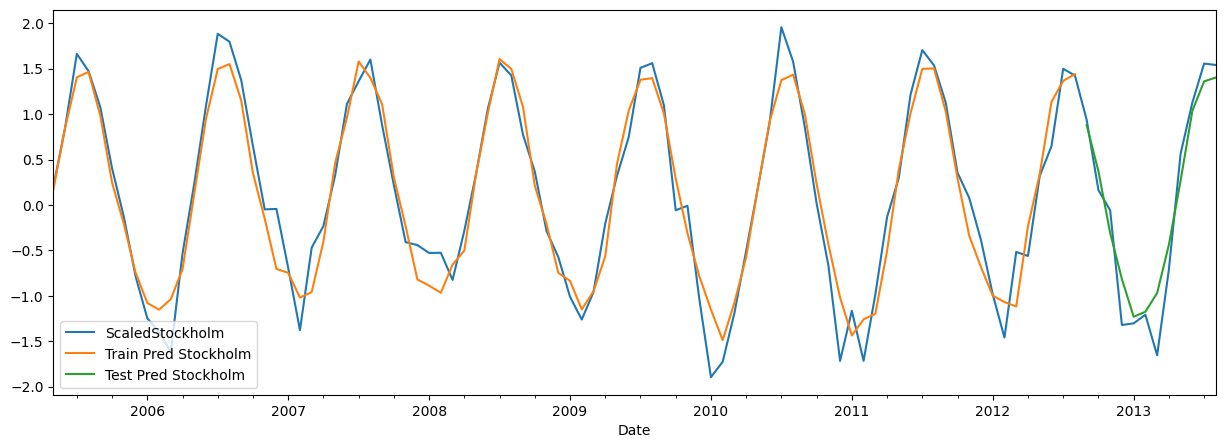

In [39]:
plot_cols = ["ScaledStockholm", "Train Pred Stockholm", "Test Pred Stockholm"]
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [43]:
y_pred = joined_part.loc[train_idx, "Train Pred Auckland"]
y_true = joined_part.loc[train_idx, "ScaledAuckland"]
print(f"Auckland Train R^2: {r2_score(y_true, y_pred)}")

y_pred = joined_part.loc[test_idx, "Test Pred Auckland"]
y_true = joined_part.loc[test_idx, "ScaledAuckland"]
print(f"Auckland Test R^2:  {r2_score(y_true, y_pred)}")

Auckland Train R^2: 0.9294897358298467
Auckland Test R^2:  0.9297610146858564


In [44]:
y_pred = joined_part.loc[train_idx, "Train Pred Stockholm"]
y_true = joined_part.loc[train_idx, "ScaledStockholm"]
print(f"Stockholm Train R^2: {r2_score(y_true, y_pred)}")

y_pred = joined_part.loc[test_idx, "Test Pred Stockholm"]
y_true = joined_part.loc[test_idx, "ScaledStockholm"]
print(f"Stockholm Test R^2:  {r2_score(y_true, y_pred)}")

Stockholm Train R^2: 0.9247008914594563
Stockholm Test R^2:  0.9308906312503245


## VAR(p)

In [45]:
# Note: We don't pass the p
model = VAR(train[cols])

In [46]:
lag_order_results = model.select_order(maxlags=15)
lag_order_results

In [47]:
lag_order_results.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [48]:
results = model.fit(maxlags=15, ic="aic")

In [49]:
# Now, get the lag order which can be accessed by the attribute k_ar
lag_order = results.k_ar
lag_order

12

In [50]:
prior = train.iloc[-lag_order:][cols].to_numpy()  # why need this?
fcast = results.forecast(prior, Ntest)

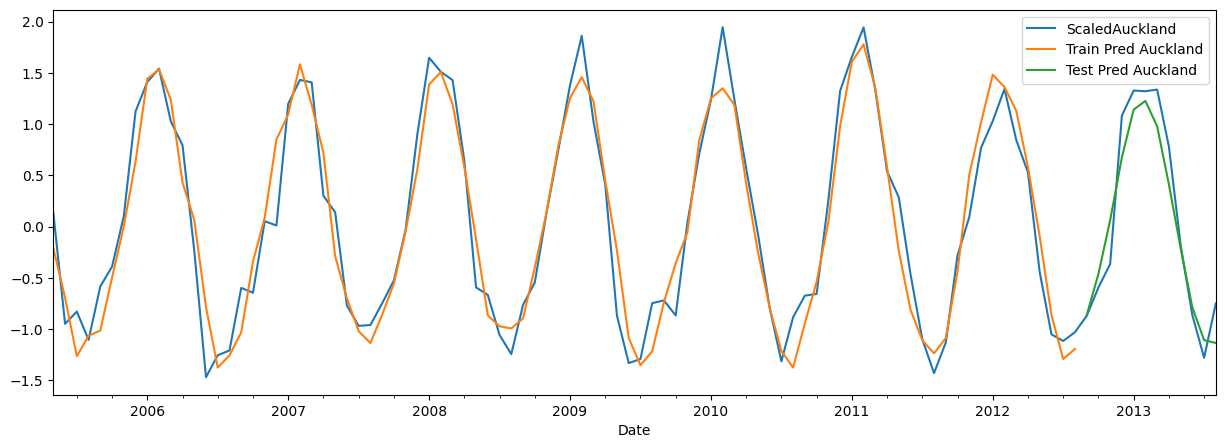

In [51]:
joined_part.loc[train_idx, "Train Pred Auckland"] = results.fittedvalues["ScaledAuckland"]
joined_part.loc[test_idx, "Test Pred Auckland"]   = fcast[:, 0]

plot_cols = ["ScaledAuckland", "Train Pred Auckland", "Test Pred Auckland"]
joined_part.iloc[-100:][plot_cols].plot(figsize = (15, 5));

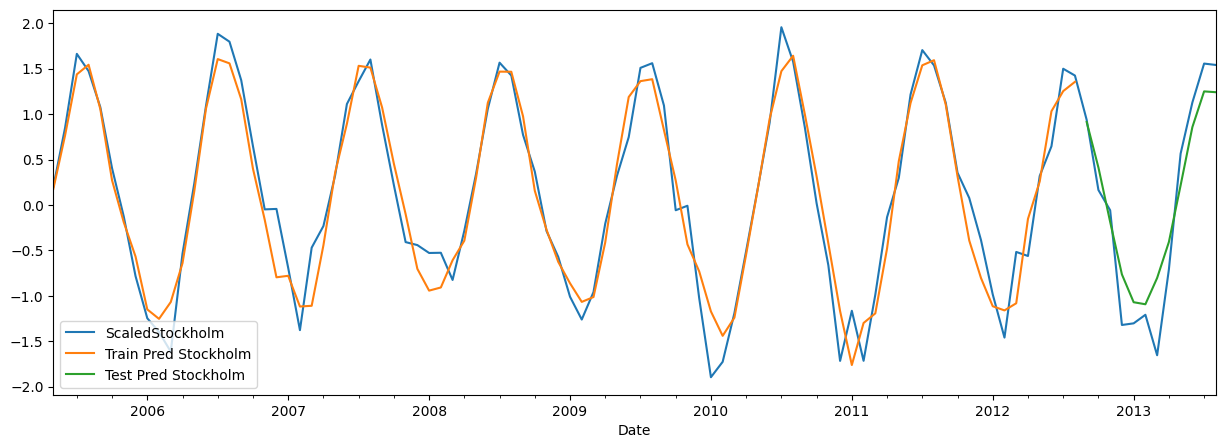

In [52]:
joined_part.loc[train_idx, "Train Pred Stockholm"] = results.fittedvalues["ScaledStockholm"]
joined_part.loc[test_idx, "Test Pred Stockholm"]   = fcast[:, 1]

plot_cols = ["ScaledStockholm", "Train Pred Stockholm", "Test Pred Stockholm"]
joined_part.iloc[-100:][plot_cols].plot(figsize = (15, 5));

In [53]:
y_pred = joined_part.loc[train_idx, "Train Pred Auckland"]
y_true = joined_part.loc[train_idx, "ScaledAuckland"]
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print(f"Auckland Train R^2: {r2_score(y_true, y_pred)}")

y_pred = joined_part.loc[test_idx, "Test Pred Auckland"]
y_true = joined_part.loc[test_idx, "ScaledAuckland"]
print(f"Auckland Test R^2:  {r2_score(y_true, y_pred)}")

Auckland Train R^2: 0.921070700106029
Auckland Test R^2:  0.9233643831340894


In [54]:
y_pred = joined_part.loc[train_idx, "Train Pred Stockholm"]
y_true = joined_part.loc[train_idx, "ScaledStockholm"]
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print(f"Stockholm Train R^2: {r2_score(y_true, y_pred)}")

y_pred = joined_part.loc[test_idx, "Test Pred Stockholm"]
y_true = joined_part.loc[test_idx, "ScaledStockholm"]
print(f"Stockholm Test R^2:  {r2_score(y_true, y_pred)}")

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2:  0.8930437688204874


## ARIMA Baseline

In [57]:
for col in cols:
    model = ARIMA(train[col], order=(10, 0, 10))
    res   = model.fit()
    fcast = res.get_forecast(Ntest)
    print(f"{col} Train R^2: {r2_score(joined_part.loc[train_idx, col], res.fittedvalues)}")
    print(f"{col} Test R^2: {r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean)}")

c:\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213758003528066
ScaledAuckland Test R^2: 0.9380629190965645
ScaledStockholm Train R^2: 0.9207489688963822
ScaledStockholm Test R^2: 0.9481383223542004


c:\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Exercise: Use Seasonal ARIMA for a more parsimonious model